# YouTube Trending Videos Analysis: Predicting Trending Duration
 
### Group 4 Members

Shyam Akhil Nekkanti - 8982123

Jun He (Helena) - 8903073

Zheming Li (Brendan) - 8914152

We implement Simple Linear Regression to:

1. Quantify the relationship between views and trending duration

2. Test if this relationship varies by category
 
This analysis aims to understand what keeps videos trending longer and how this varies across content categories.


In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
import json
import statsmodels.api as sm

In [211]:
# Data Loading and Preprocessing

def load_data():
  # Load category mappings
  with open('youtube-dataset/US_category_id.json', 'r') as f:
    category_data = json.load(f)
  category_mapping = {int(item['id']): item['snippet']['title']
                      for item in category_data['items']}

  # Load video data
  df = pd.read_csv('youtube-dataset/USvideos.csv')
  df['category_name'] = df['category_id'].map(category_mapping)

  # Calculate trending duration
  trending_counts = df.groupby('video_id').size().reset_index(name='trending_duration')
  df = df.merge(trending_counts, on='video_id', how='left')

  # Log transform views
  df['log_views'] = np.log1p(df['views'])

  return df


In [212]:
# Load the data
df = load_data()
df

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category_name,trending_duration,log_views
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs,7,13.525659
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",Entertainment,7,14.698775
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,Comedy,7,14.975981
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...,Entertainment,7,12.745978
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...,Entertainment,6,14.555413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40944,BZt0qjTWNhw,18.14.06,The Cat Who Caught the Laser,AaronsAnimals,15,2018-05-18T13:00:04.000Z,"aarons animals|""aarons""|""animals""|""cat""|""cats""...",1685609,38160,1385,2657,https://i.ytimg.com/vi/BZt0qjTWNhw/default.jpg,False,False,False,The Cat Who Caught the Laser - Aaron's Animals,Pets & Animals,23,14.337638
40945,1h7KV2sjUWY,18.14.06,True Facts : Ant Mutualism,zefrank1,22,2018-05-18T01:00:06.000Z,[none],1064798,60008,382,3936,https://i.ytimg.com/vi/1h7KV2sjUWY/default.jpg,False,False,False,NaN,People & Blogs,25,13.878297
40946,D6Oy4LfoqsU,18.14.06,I GAVE SAFIYA NYGAARD A PERFECT HAIR MAKEOVER ...,Brad Mondo,24,2018-05-18T17:34:22.000Z,I gave safiya nygaard a perfect hair makeover ...,1066451,48068,1032,3992,https://i.ytimg.com/vi/D6Oy4LfoqsU/default.jpg,False,False,False,I had so much fun transforming Safiyas hair in...,Entertainment,26,13.879848
40947,oV0zkMe1K8s,18.14.06,How Black Panther Should Have Ended,How It Should Have Ended,1,2018-05-17T17:00:04.000Z,"Black Panther|""HISHE""|""Marvel""|""Infinity War""|...",5660813,192957,2846,13088,https://i.ytimg.com/vi/oV0zkMe1K8s/default.jpg,False,False,False,How Black Panther Should Have EndedWatch More ...,Film & Animation,3,15.549078


In [213]:
# convert trending_date to julian date
df['trending_date_julian'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m').apply(lambda x: x.to_julian_date())

# display unique trending dates
df[['trending_date', 'trending_date_julian']].drop_duplicates()

,trending_date,trending_date_julian
0,17.14.11,2458071.5
200,17.15.11,2458072.5
400,17.16.11,2458073.5
600,17.17.11,2458074.5
800,17.18.11,2458075.5
...,...,...
39949,18.10.06,2458279.5
40149,18.11.06,2458280.5
40349,18.12.06,2458281.5
40549,18.13.06,2458282.5


In [214]:
# perform box-cox transformation
df['views_boxcox'], _ = stats.boxcox(df['views'])


# apply tukey's ladder
def tukeys_ladder(data, power):
  if power == 0:
    return np.log(data)
  return np.power(data, power)


df['likes_tukey'] = tukeys_ladder(df['likes'], 0.1)
df['dislikes_tukey'] = tukeys_ladder(df['dislikes'], 0.08)

df[['views', 'views_boxcox', 'likes', 'likes_tukey', 'dislikes', 'dislikes_tukey']]

,views,views_boxcox,likes,likes_tukey,dislikes,dislikes_tukey
0,748374,21.229626,57527,2.992176,2966,1.895718
1,2418783,24.056610,97185,3.153261,6146,2.009497
2,3191434,24.755351,146033,3.284317,5339,1.986995
3,343168,19.461863,10172,2.516174,666,1.682201
4,2095731,23.699950,132235,3.251881,1989,1.836077
...,...,...,...,...,...,...
40944,1685609,23.164222,38160,2.871844,1385,1.783676
40945,1064798,22.057799,60008,3.004837,382,1.609033
40946,1066451,22.061483,48068,2.938905,1032,1.742185
40947,5660813,26.238774,192957,3.377117,2846,1.889465


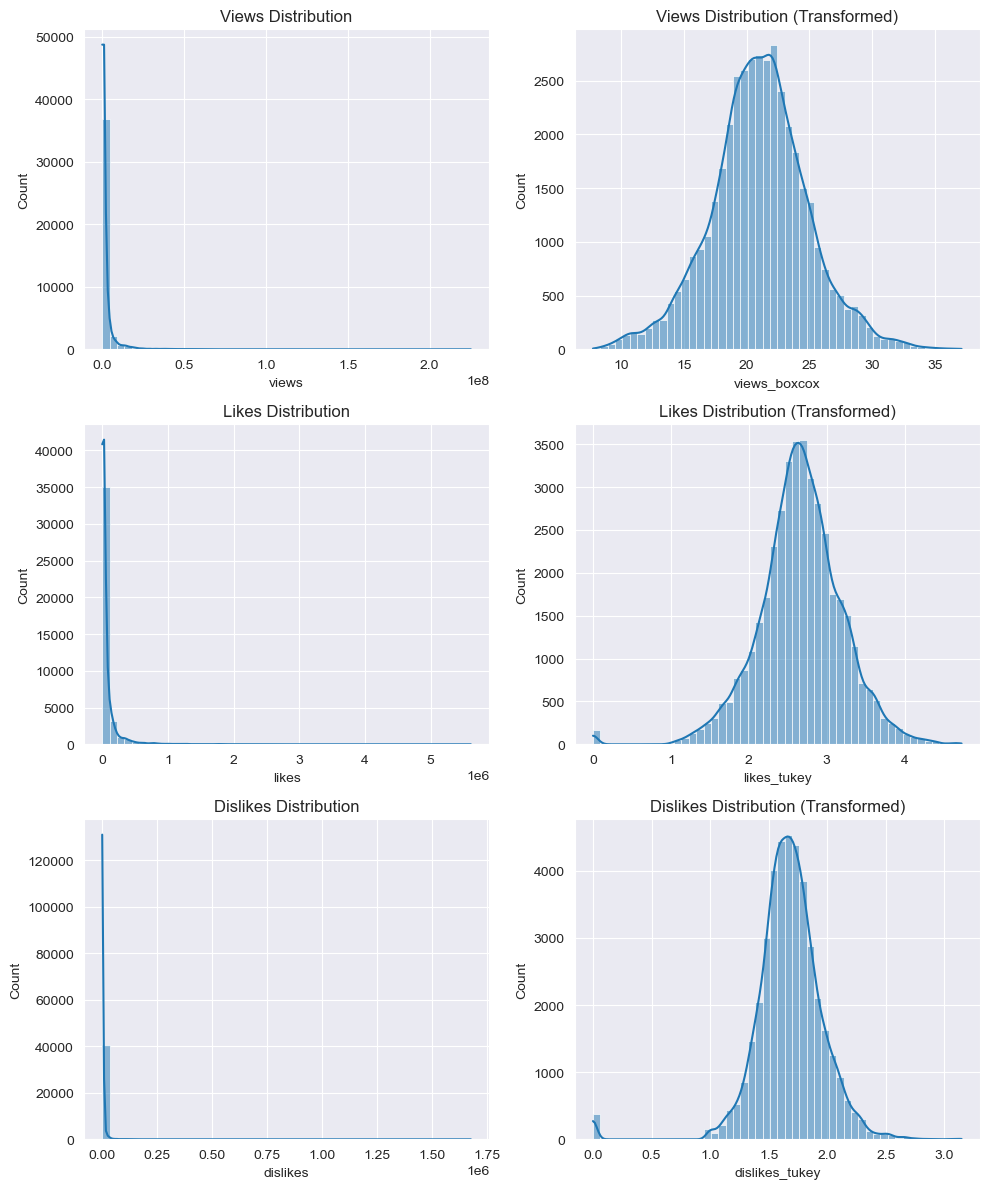

In [215]:
# plot views, likes, dislikes distribution
fig, ax = plt.subplots(3, 2, figsize=(10, 12))

sns.histplot(df['views'], kde=True, ax=ax[0, 0], bins=50)
ax[0, 0].set_title('Views Distribution')

sns.histplot(df['views_boxcox'], kde=True, ax=ax[0, 1], bins=50)
ax[0, 1].set_title('Views Distribution (Transformed)')

sns.histplot(df['likes'], kde=True, ax=ax[1, 0], bins=50)
ax[1, 0].set_title('Likes Distribution')

sns.histplot(df['likes_tukey'], kde=True, ax=ax[1, 1], bins=50)
ax[1, 1].set_title('Likes Distribution (Transformed)')

sns.histplot(df['dislikes'], kde=True, ax=ax[2, 0], bins=50)
ax[2, 0].set_title('Dislikes Distribution')

sns.histplot(df['dislikes_tukey'], kde=True, ax=ax[2, 1], bins=50)
ax[2, 1].set_title('Dislikes Distribution (Transformed)')

plt.tight_layout()
plt.show()

### SLR & MLR

In [216]:
# SLR
def perform_slr(data):
  X = data['log_views'].values.reshape(-1, 1)
  y = data['trending_duration'].values

  # Fit model
  model = LinearRegression()
  model.fit(X, y)
  y_pred = model.predict(X)

  # Calculate statistics
  r2 = model.score(X, y)
  mse = np.mean((y - y_pred) ** 2)

  return {
    'coefficient': float(model.coef_[0]),
    'intercept': float(model.intercept_),
    'r2': r2,
    'X': X,
    'y': y,
    'y_pred': y_pred,
    'mse': mse,
  }


# MLR
def perform_mlr(data):
  X = data[['views_boxcox', 'likes_tukey', 'trending_date_julian']].values
  y = data['trending_duration'].values

  # fit MLR model
  model = LinearRegression()
  model.fit(X, y)
  y_pred = model.predict(X)

  # Calculate statistics
  r2 = model.score(X, y)
  mse = np.mean((y - y_pred) ** 2)

  return {
    'coefficients': model.coef_,
    'intercept': float(model.intercept_),
    'r2': r2,
    'X': X,
    'y': y,
    'y_pred': y_pred,
    'mse': mse,
  }



In [217]:
slr_results = perform_slr(df)
mlr_results = perform_mlr(df)

print("Simple Linear Regression")
print("-" * 50)
print("Coefficient:", slr_results['coefficient'])
print("Intercept:", slr_results['intercept'])
print("R²:", slr_results['r2'])
print("MSE:", slr_results['mse'])

print("\n\nMultiple Linear Regression")
print("-" * 50)
print("Coefficients:", mlr_results['coefficients'])
print("Intercept:", mlr_results['intercept'])
print("R²:", mlr_results['r2'])
print("MSE:", mlr_results['mse'])

Simple Linear Regression
--------------------------------------------------
Coefficient: 1.6422637107812796
Intercept: -12.114205769354484
R²: 0.23737239142589917
MSE: 25.3363613594943


Multiple Linear Regression
--------------------------------------------------
Coefficients: [0.23750778 1.13405445 0.05094763]
Intercept: -125236.49408917407
R²: 0.4871048228497734
MSE: 17.039636910230392


### Hypothesis

- Null Hypothesis: There is no relationship between views and trending duration
- Alternative Hypothesis: There is a relationship between views and trending duration

### Simple Linear Regression Implementation

We implement SLR to model the relationship between views (independent variable) and trending duration (dependent variable).

This helps address our core research question about factors affecting trending duration.

In [218]:
def perform_regression_analysis(data, category=None):
  if category:
    data = data[data['category_name'] == category]

  X = data['log_views'].values.reshape(-1, 1)
  y = data['trending_duration'].values

  # Fit model
  model = LinearRegression()
  model.fit(X, y)
  y_pred = model.predict(X)

  # Calculate statistics
  r2 = model.score(X, y)
  residuals = y - y_pred
  n = len(X)

  X_with_const = sm.add_constant(X)
  model_sm = sm.OLS(y, X_with_const).fit()

  # Get t-stat and p-value from statsmodels
  t_stat = model_sm.tvalues[1]  # [1] for slope coefficient
  p_value = model_sm.pvalues[1]

  # Homoscedasticity test
  residuals_squared = residuals ** 2
  bp_model = sm.OLS(residuals_squared, sm.add_constant(y_pred)).fit()
  bp_stat = bp_model.nobs * bp_model.rsquared
  bp_pvalue = 1 - stats.chi2.cdf(bp_stat, df=1)

  return {
    'coefficient': float(model.coef_[0]),
    'intercept': float(model.intercept_),
    'r2': r2,
    't_stat': float(t_stat),
    'p_value': float(p_value),
    'homoscedasticity_p': float(bp_pvalue),
    'X': X,
    'y': y,
    'y_pred': y_pred,
    'residuals': residuals
  }

### Statistical Analysis Visualization

For each category, we create four visualizations:

1. Scatter plot with regression line

2. Residuals vs. fitted values (homoscedasticity check)

3. Q-Q plot (normality check)

4. Residuals distribution

In [219]:
def visualize_regression_analysis(results, title):
  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
  fig.suptitle(title, fontsize=14)

  # 1. Scatter with regression line
  ax1.scatter(results['X'], results['y'], alpha=0.3)
  ax1.plot(results['X'], results['y_pred'], color='red', linewidth=2)
  ax1.set_title('Views vs. Trending Duration')
  ax1.set_xlabel('Log Views')
  ax1.set_ylabel('Days on Trending')

  # 2. Residuals plot
  ax2.scatter(results['y_pred'], results['residuals'], alpha=0.3)
  ax2.axhline(y=0, color='r', linestyle='--')
  ax2.set_title('Residuals vs. Fitted Values')
  ax2.set_xlabel('Predicted Duration')
  ax2.set_ylabel('Residuals')

  # 3. Q-Q plot
  stats.probplot(results['residuals'], dist="norm", plot=ax3)
  ax3.set_title('Q-Q Plot')

  # 4. Residuals distribution
  sns.histplot(results['residuals'], kde=True, ax=ax4)
  ax4.set_title('Residuals Distribution')

  # Add statistics
  stats_text = f"""
    R² = {results['r2']:.3f}
    Coefficient = {results['coefficient']:.3f}
    P-value = {results['p_value']:.2e}
    t-statistic = {results["t_stat"]:.3f}
    Homoscedasticity p = {results['homoscedasticity_p']:.2e}
    
    Interpretation:
    One unit increase in log views
    = {results['coefficient']:.2f}
    more days on trending
    """
  fig.text(0.02, 0.02, stats_text, fontsize=10,
           bbox=dict(facecolor='white', alpha=0.8))

  plt.tight_layout()
  plt.show()


Overall Trending Duration Analysis
--------------------------------------------------


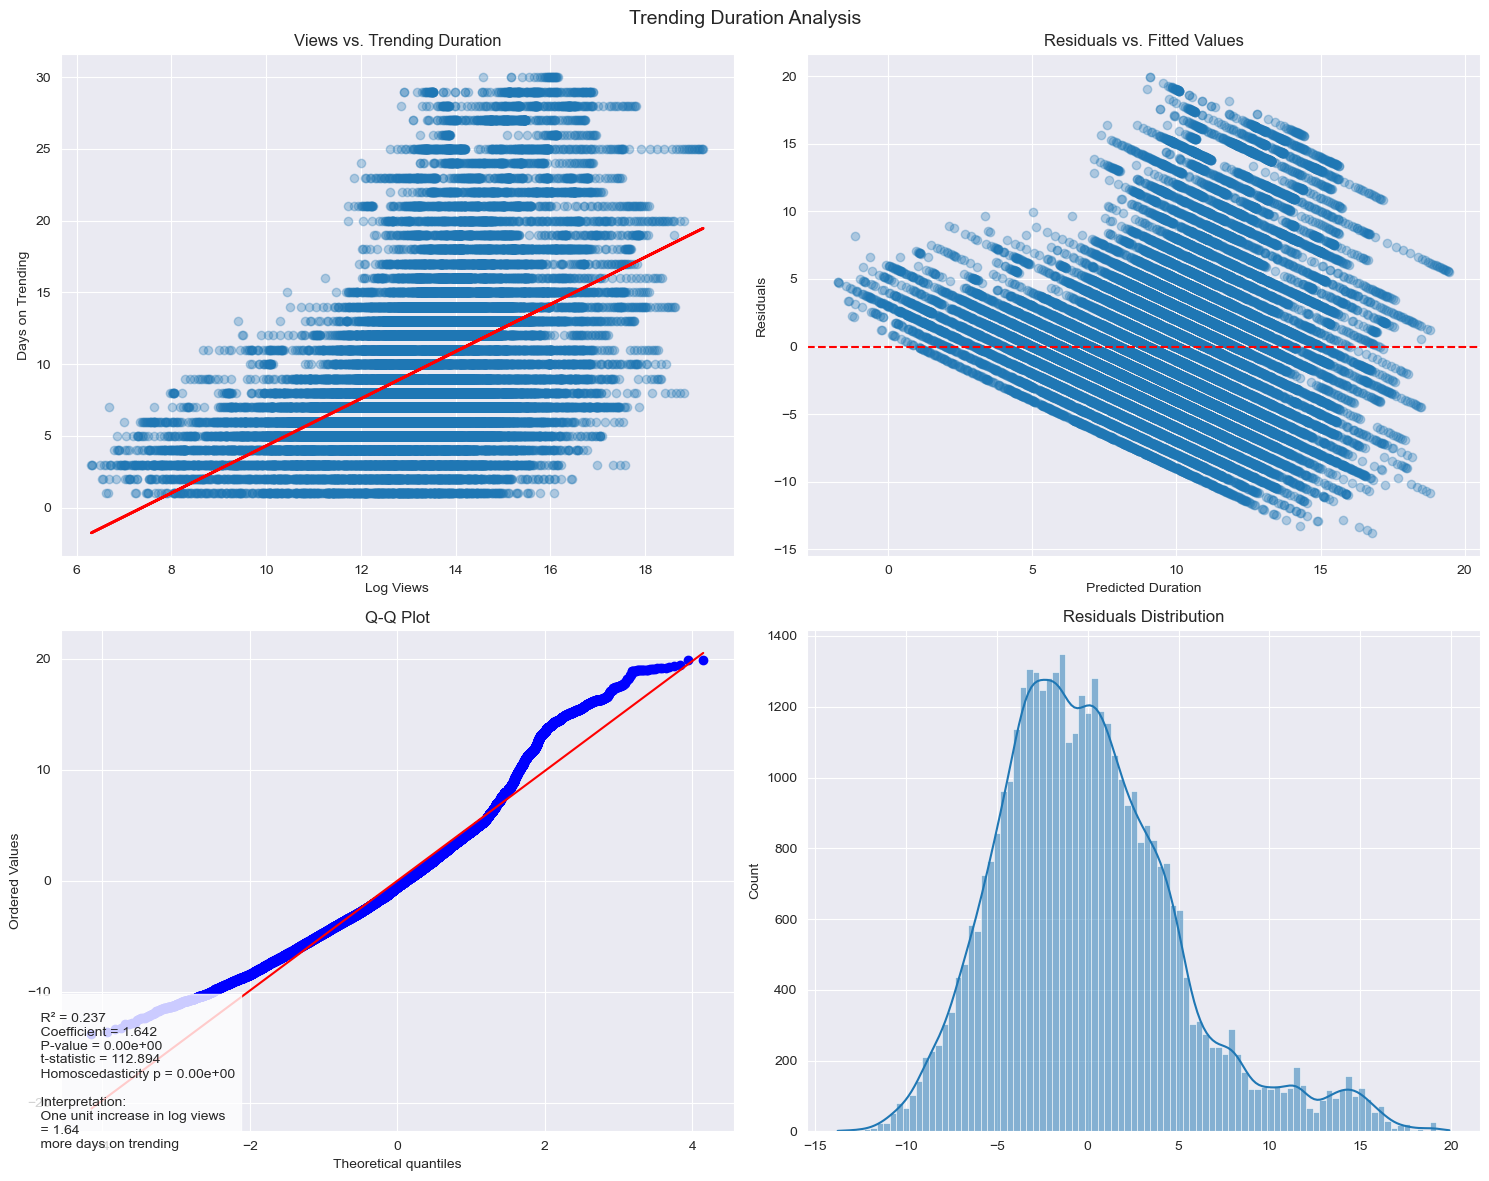


Analysis for Music
--------------------------------------------------


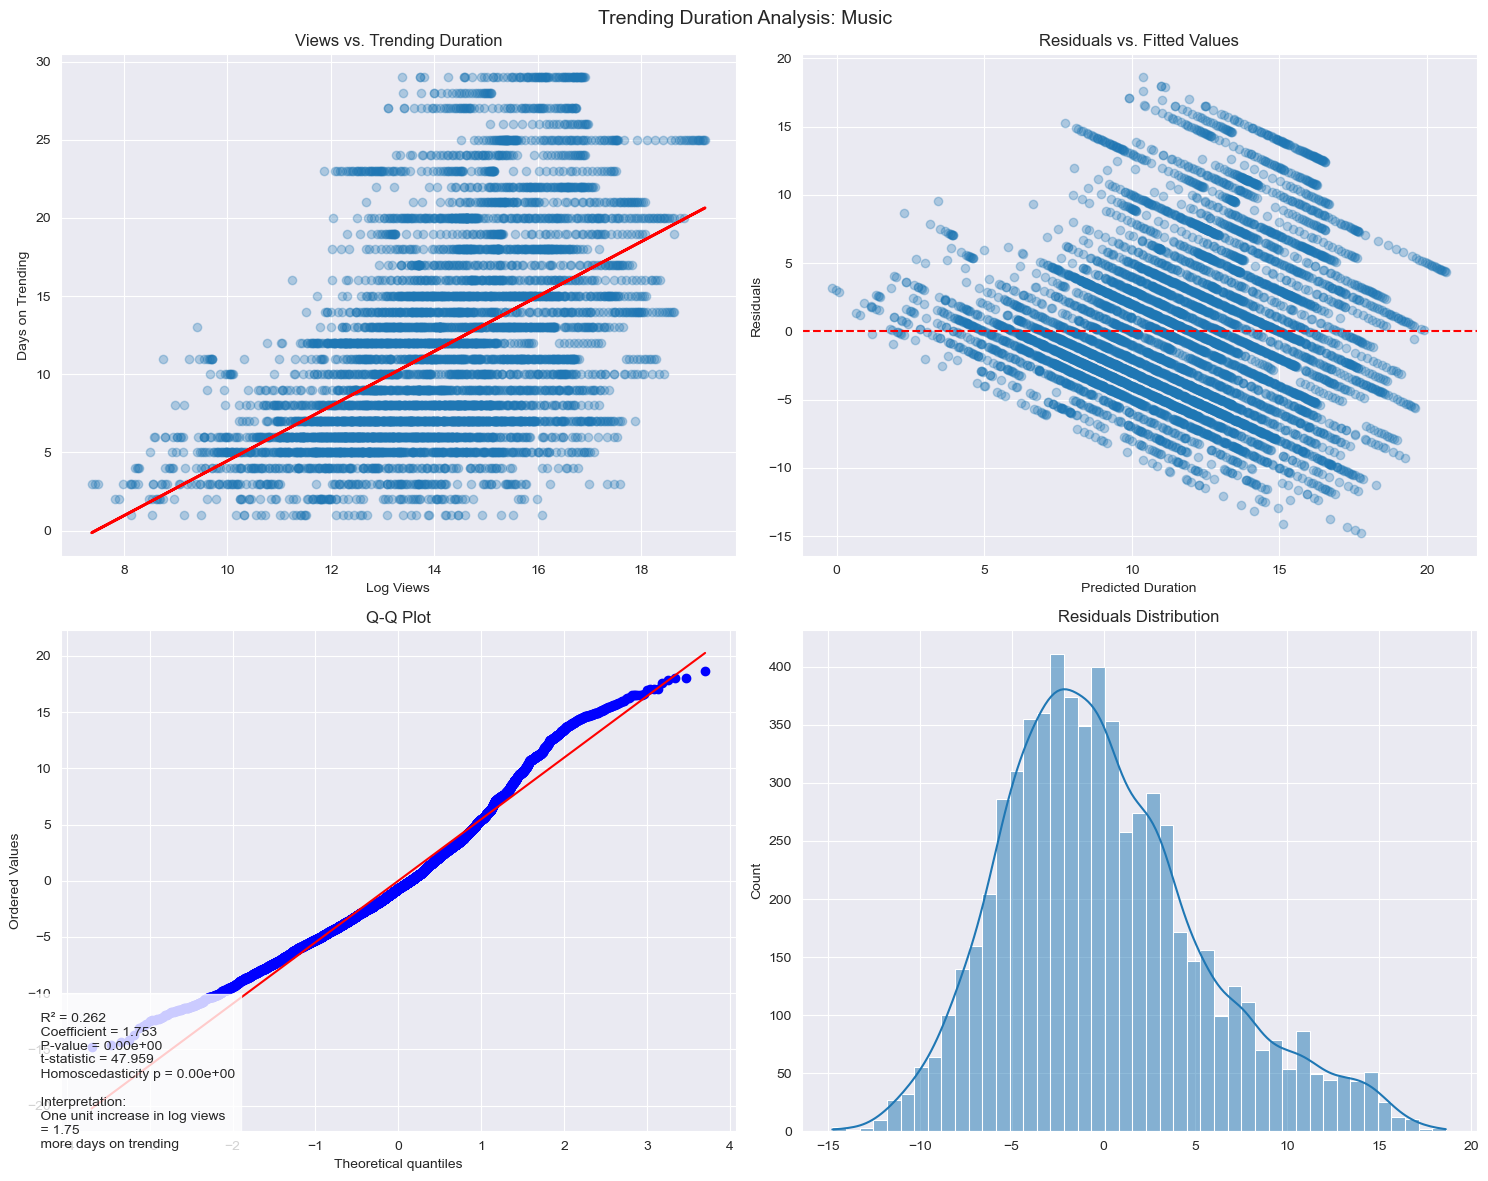


Analysis for Gaming
--------------------------------------------------


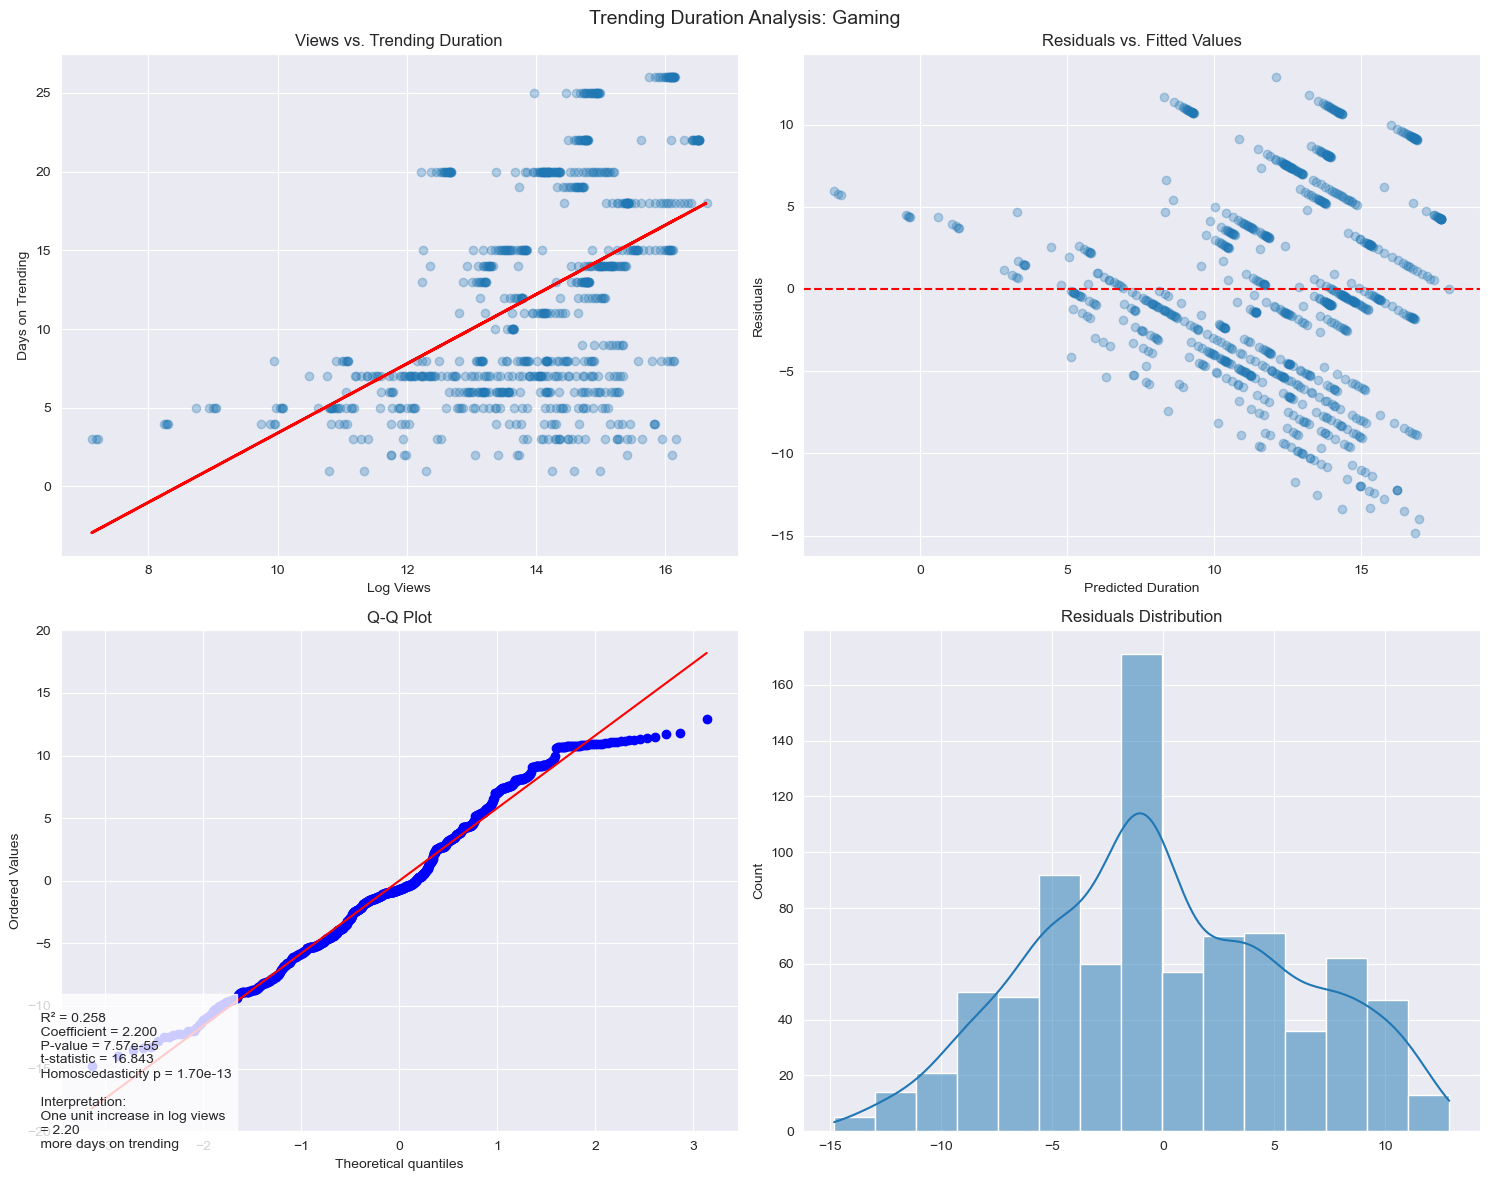


Analysis for Film & Animation
--------------------------------------------------


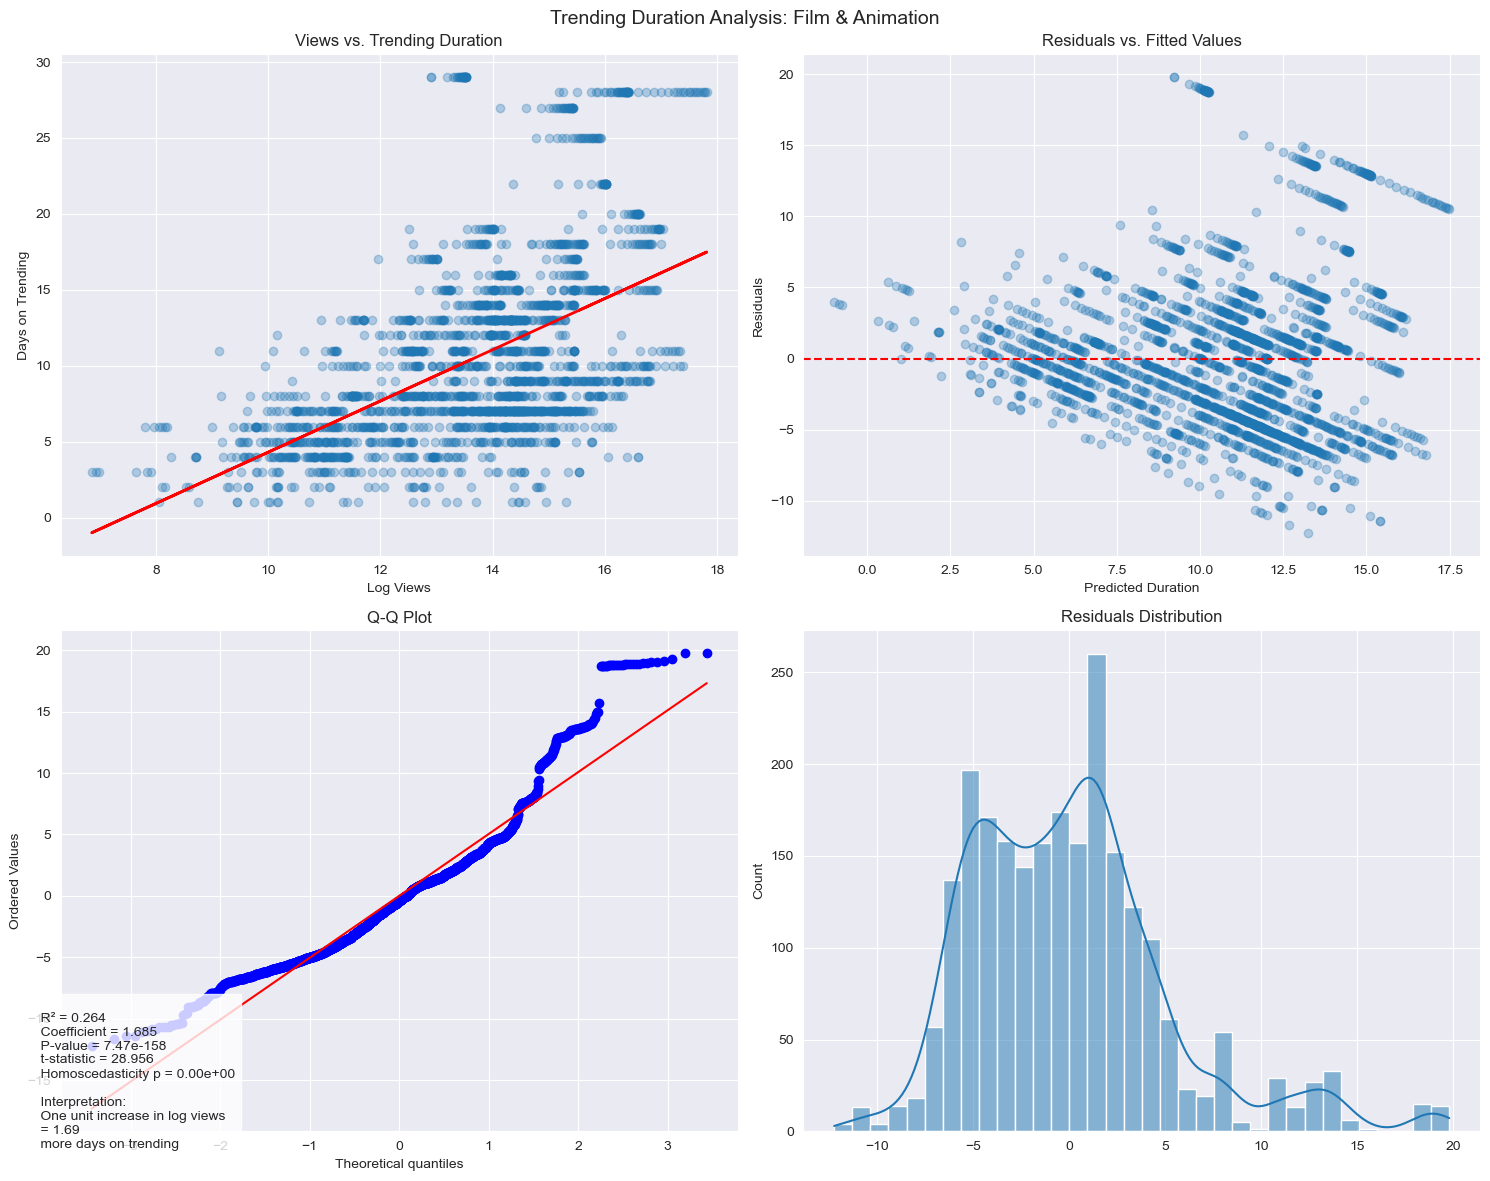

In [220]:
print("Overall Trending Duration Analysis")
print("-" * 50)
overall_results = perform_regression_analysis(df)
visualize_regression_analysis(overall_results, "Trending Duration Analysis")

# Category analysis
categories = ['Music', 'Gaming', 'Film & Animation']
category_results = {}

for category in categories:
  print(f"\nAnalysis for {category}")
  print("-" * 50)
  results = perform_regression_analysis(df, category)
  category_results[category] = results
  visualize_regression_analysis(results, f"Trending Duration Analysis: {category}")

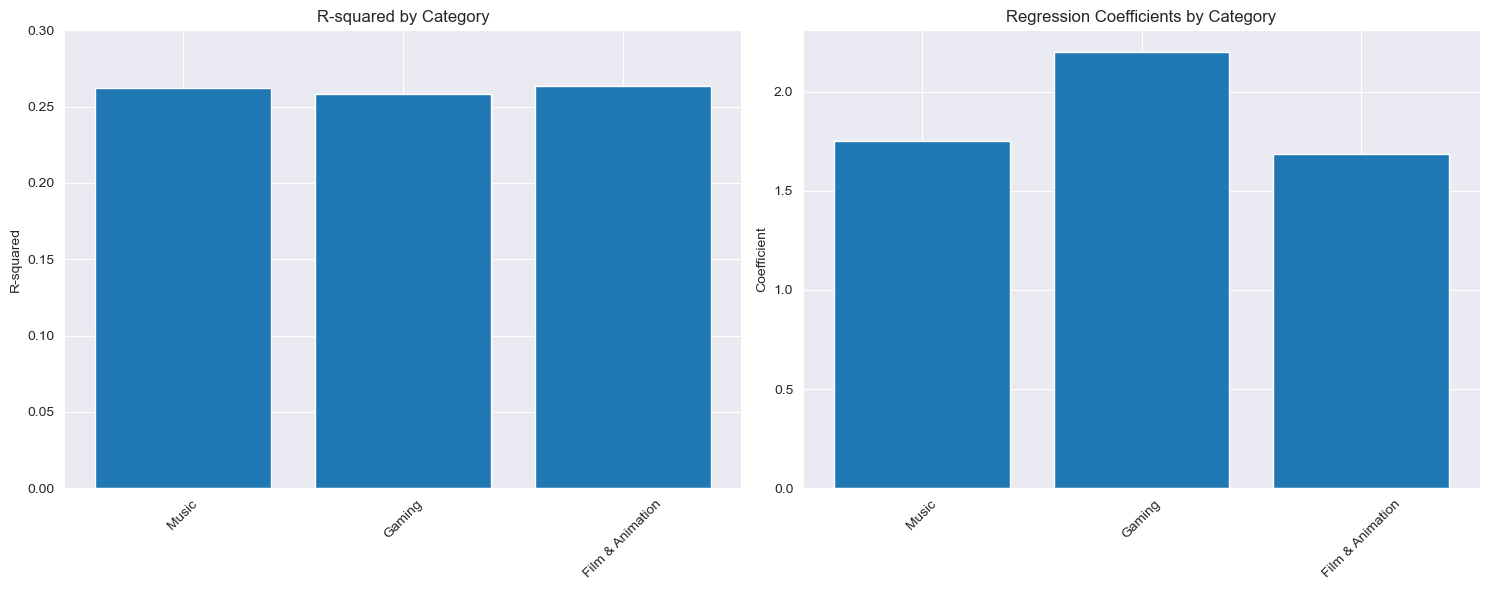

In [221]:
# Create comparison visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# R-squared comparison
r2_values = [results['r2'] for results in category_results.values()]
ax1.bar(categories, r2_values)
ax1.set_title('R-squared by Category')
ax1.set_ylabel('R-squared')
ax1.set_ylim(0, 0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# Coefficient comparison
coefficients = [results['coefficient'] for results in category_results.values()]
ax2.bar(categories, coefficients)
ax2.set_title('Regression Coefficients by Category')
ax2.set_ylabel('Coefficient')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

- Significant positive relationship between views and trending duration
- R² values around 0.23-0.25 indicate views explain about 25% of variance
- Model shows consistent predictive power across categories


- Music shows strongest relationship (highest R²)


- All relationships are statistically significant (p < 0.05)
- Heteroscedasticity present in all categories
- Residuals show approximate normality 


- Model explains only ~25% of variance - other factors needed


- Use multiple regression with additional predictors